<a href="https://colab.research.google.com/github/karencfisher/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [0]:
import matplotlib.pyplot as plt


In [4]:
df.head()

bathrooms  bedrooms  ... wheelchair_access common_outdoor_space
0        1.5         3  ...                 0                    0
1        1.0         2  ...                 0                    0
2        1.0         1  ...                 0                    0
3        1.0         1  ...                 0                    0
4        1.0         4  ...                 0                    0

[5 rows x 34 columns]

## Feature Engineering

I was very interested in classifying the listings by neighborhoods. To do this, I found a list of Manhattan neighborhoods, ordered by average rents, from https://www.rentcafe.com/average-rent-market-trends/us/ny/manhattan/. I then used Google Map's API for geocoding to get the approximate center latitude and longitude for each. With this I constructed the dataframe loaded below. (The work for this is on a separate noteook, https://colab.research.google.com/drive/12kKaqgN-Pz3uVFuOrDKJLrEh9EtoiW2c#scrollTo=5DPVaXMIMKkk.)

I then found the minimum distances between each listing and the centeroids of the neighborhoods, essentially clustering them (by, I guess, nearest neighbors) and approximately classified each listing by neighborhood.

In [5]:
# Get my data set of Manhattan neighborhood centroid coordinates. They are also
# sorted by average rents.
url = 'https://raw.githubusercontent.com/karencfisher/DS-Unit-2-Linear-Models/master/module2-regression-2/manhattan_neighborhoods.csv'
neighborhood_df = pd.read_csv(url)
neighborhood_df.head()

Unnamed: 0                Neighborhood Average Rent   latitude  longitude
0           0                 Marble Hill       $1,708  40.876117 -73.910263
1           1          Washington Heights       $2,284  40.841708 -73.939355
2           2                      Inwood       $2,375  40.867715 -73.921202
3           3  Randalls and Wards Islands       $2,394  40.793227 -73.921286
4           4                      Harlem       $2,948  40.811550 -73.946477

In [6]:
# Find nearest centroid for each apartment, classifying them approximately
# into neighborhoods
from scipy.spatial import distance

distances = distance.cdist(df[['latitude', 'longitude']], neighborhood_df[['latitude', 'longitude']], metric='cityblock')
clusters = np.argmin(distances, axis=1)
df['neighborhood'] = clusters
df[['latitude', 'longitude', 'neighborhood']].head(10)

latitude  longitude  neighborhood
0   40.7145   -73.9425            41
1   40.7947   -73.9667            42
2   40.7388   -74.0018            31
3   40.7539   -73.9677            12
4   40.8241   -73.9493             4
5   40.7429   -74.0028            30
6   40.8012   -73.9660            42
7   40.7427   -73.9957            27
8   40.8234   -73.9457             4
9   40.7278   -73.9808            28

In [7]:
# Plot rents over neighborhoods.
import plotly.express as px
fig = px.scatter(df, x='neighborhood', y='price', trendline='ols')
fig.update_layout(
    title_text='Rents by neighborhoods'
)
fig.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



I did think the trendline when I plotted prices by neighborhood, would be more profound. 

### Amenities

This feature is basically the sum of all the binomial 'perk' features, such as allowing pets, the presence of an elevator or doorman, an outdoor area, and so forth. So I just sum them all up for each listing.

In [8]:
df['amenities'] = np.NaN

df['amenities'] = df[['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space']].sum(axis=1)

df['amenities'].head()

0    0
1    5
2    3
3    2
4    1
Name: amenities, dtype: int64

In [9]:
# Plot rents by total amenities.
fig = px.scatter(df, x='amenities', y='price', trendline='ols', opacity=.5)
fig.update_layout(
    title_text='Rents by total amenities'
)
fig.show()

## Date of listing

I wondered if there was a significance in how long a given listing was still on the list. I assumed these were as listed in June of 2016, but some are there since April. I wondered if there may be some correlation.

There appears to be none, but I did need to convert the date/times to the proper format, and pull out the months for doing the time based splitting between training and testing data.

In [0]:
df['created'] = pd.to_datetime(df['created'])


In [11]:
newest = df['created'].max()
df['listing_age'] = ((newest-df['created'])/ np.timedelta64(1, 'D')).astype(int)
df['listing_month'] = df['created'].dt.month
df[['created', 'listing_age', 'listing_month']].sample(10)

created  listing_age  listing_month
14623 2016-06-12 08:51:15           17              6
11888 2016-06-21 03:23:25            8              6
19550 2016-06-06 14:23:38           23              6
1367  2016-04-02 02:44:41           88              4
35604 2016-05-14 04:51:44           46              5
1021  2016-04-21 01:17:23           69              4
40018 2016-05-12 05:31:08           48              5
34775 2016-05-18 05:54:41           42              5
25045 2016-05-07 03:31:40           53              5
30354 2016-05-03 02:28:22           57              5

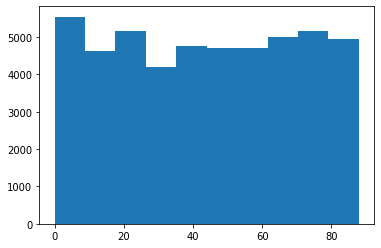

In [12]:
plt.hist(df['listing_age']);

In [13]:
# Plot rents by age of listing.
fig = px.scatter(df, x='listing_age', y='price', trendline='ols', opacity=.5)
fig.update_layout(
    title_text='Rents by age of listing'
)
fig.show()

### Count of words in descriptions

I thought, 'nah, that can't be relevant. OK, I'll try it anway.' So I calculated the number of words in each description as a new, engineered feature. Since there were missing values in the description column, I replace NaNs with empty strings, so they'd be counted as 0 words. And, to my surprise, there is some correlation with prices on average higher the wordier the description.

In [14]:
df['description'].dtypes

dtype('O')

In [15]:
df['description'].isnull().sum()

1425

In [0]:
df['description'].fillna('', inplace=True)

In [17]:
df['words_in_description'] = np.NAN
for row in df.index:
  df.at[row, 'words_in_description'] = len(df.loc[row]['description'].split())
df[['description', 'words_in_description']].head()

description  words_in_description
0  A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...                  93.0
1                                                                      0.0
2  Top Top West Village location, beautiful Pre-w...                  92.0
3  Building Amenities - Garage - Garden - fitness...                  78.0
4  Beautifully renovated 3 bedroom flex 4 bedroom...                  67.0

In [18]:
# Plot rents by words in description.
import plotly.express as px
fig = px.scatter(df, x='words_in_description', y='price', trendline='ols', opacity=.5)
fig.update_layout(
    title_text='Rents by words in description'
)
fig.show()

##The moments of truth

Train a linear model with five features: bedrooms, bathrooms, and the engineered features of neighborhood, amenities, and word counts in the descriptions.

Split into train and test data by months (up to and after May).



In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

Put regression steps together in a single function so it can be reused.

In [0]:
def linearModel(df, features, target):
  '''
  Linear model

  Inputs:
  df - the data frame
  features - list of features
  target - the target as series

  Returns the resultant model and metrics as a table
  '''

  # Separate dataframe into X (features), and y (target)
  X = df[features]
  y = df[target]

  # Time series split into training and testing data sets
  X_train = df[df['listing_month'] <= 5][features]
  X_test = df[df['listing_month'] > 5][features]
  y_train = df[df['listing_month'] <= 5][target]
  y_test = df[df['listing_month'] > 5][target]

  # Train the model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Get metrics for train data
  y_hat = model.predict(X_train)
  train_r2 = r2_score(y_train, y_hat)
  train_rsme = np.sqrt(mean_squared_error(y_train, y_hat))
  train_mae = mean_absolute_error(y_train, y_hat)

  # Get metrics for test data
  y_hat = model.predict(X_test)
  test_r2 = r2_score(y_test, y_hat)
  test_rsme = np.sqrt(mean_squared_error(y_test, y_hat))
  test_mae = mean_absolute_error(y_test, y_hat)

  results = {'Training_data': {'R2': train_r2, 'RSME': train_rsme, 'MAE': train_mae},
            'Test_data':      {'R2': test_r2, 'RSME': test_rsme, 'MAE': test_mae}}
  result_table = pd.DataFrame(results)
  return model, result_table



In [21]:
model1, result = linearModel(df, ['bedrooms', 'bathrooms', 'amenities', 'neighborhood',
                                  'words_in_description'], 'price')
result

Training_data    Test_data
R2         0.545420     0.555584
RSME    1188.059090  1175.267182
MAE      783.588097   787.190889

In [22]:
model1.coef_, model1.intercept_

(array([ 4.06828995e+02,  1.90019129e+03,  8.06424185e+01,  1.50937661e+01,
        -2.84213728e-01]), -92.27419770228653)

##Stretch 

Looking at the data, I notice there are still wide differences in variances between the prices, on one hand, and all the other features we are using, on the other hand. How will that affect the linear regression?

What happens if we normalize the data before training the linear model? Let's give it a shot!

In [0]:
from sklearn.preprocessing import StandardScaler

In [24]:
# Get the data from the original datframe (with the engineered features), filter for
# the same five features, price. Add months without normalizing.
normalized = StandardScaler().fit_transform(df[['price', 'bedrooms', 
            'bathrooms', 'amenities', 'neighborhood', 'words_in_description']])

# make into a dataframe
df_normalize = pd.DataFrame(normalized, columns=['price', 'bedrooms', 
            'bathrooms', 'amenities', 'neighborhood', 'words_in_description'])
df_normalize['listing_month'] = df['listing_month']
df_normalize.sample(10)

price  bedrooms  ...  words_in_description  listing_month
31439 -0.045157  0.418462  ...             -0.249720            5.0
31263 -0.671571  1.322560  ...             -1.499391            5.0
11440 -0.555821 -0.485635  ...             -0.609214            6.0
11100 -0.272119 -1.389732  ...              0.914358            6.0
46888 -0.896263  0.418462  ...              0.948596            6.0
35079 -0.953003 -1.389732  ...             -0.523620            5.0
24716 -0.161475  0.418462  ...             -1.499391            5.0
9902  -0.130268  0.418462  ...              2.728950            4.0
18517 -0.486030 -1.389732  ...              0.400794            6.0
18826 -0.045157  0.418462  ...             -0.249720            6.0

[10 rows x 7 columns]

In [25]:
model2, result2 = linearModel(df_normalize, ['bedrooms', 'bathrooms', 'amenities',
                                'neighborhood', 'words_in_description'], 'price')
result2

Training_data  Test_data
R2         0.547652   0.550818
RSME       0.674266   0.667669
MAE        0.445964   0.444230

In [26]:
model2.coef_, model2.intercept_

(array([ 0.25280429,  0.51104877,  0.15378961,  0.10973109, -0.00739636]),
 -0.003415628985809808)

##Whoa! 

What a difference **normalization** makes. However, R^2 is about the same as without normalization. So I really can't say the model is better than without it.

Also, predicting an individual listing's would be difficult. The model becomes more opaque. I suppose if one can normalize data, and then 'denormalize' it back (like encode and decode it), you could normalize the input and then denormalize the predicted price? Without loss? Is it worth doing all that, unless the model proves to be superior?

I want to see how the data looks, in a univariate model. We'll try it with just the meighborhood feature.

In [27]:
model3, result3 = linearModel(df_normalize, ['neighborhood'], 'price')
result3

Training_data  Test_data
R2         0.016127   0.015809
RSME       0.994408   0.988302
MAE        0.679133   0.674501

In [28]:
model3.coef_, model3.intercept_

(array([0.12782037]), 0.0005989090421078412)

In [0]:
def plotModel(df, feature, target, model):
  '''
  Plot univariate model

  Inputs:
  df: dataframe
  feature: the independent variable
  target: thedependent variable
  model: the model from the regression process

  Output:
  A scatter plot showing the regression line and the mean y also as a baseline.
  '''

  assert len(feature) == 1, 'Only suitable to plot a univariate model!'

  # Get the predicted values across the dataframe
  y_predict = model.predict(df[feature])
  
  # Separate feature and target as X and y
  X = df[feature]
  y = df[target]

  # Plot the data, mean (as baseline), and predicted line
  fig = plt.figure(figsize=(10, 7))
  plt.scatter(X, y, alpha=.3)
  plt.plot(X, y_predict, color='red', label=f'Predict {target}')
  plt.axhline(y.mean(), color='green', dashes=(1,2), label=f'Mean {target}')
  plt.title('Data and line of best fit')
  plt.xlabel(feature)
  plt.ylabel(target)
  plt.legend()
  plt.show()


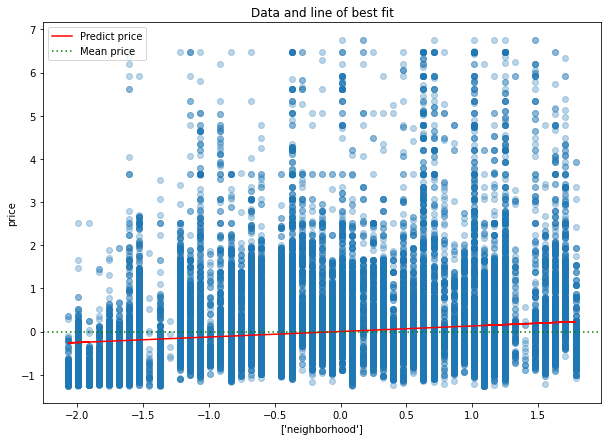

In [30]:
plotModel(df_normalize, ['neighborhood'], 'price', model3)

### Another concept

Two step process: first, use KMeans to cluster the listings by latitude and longitude. Then use the resulting labels instead of the extracted neighborhood feature above, in training the linear regression. So the listings are geographically grouped intrinsically, rather than with any preconceived scheme.

In [0]:
from sklearn.cluster import KMeans

In [0]:
def newModel(df, geodata, k, features, target):
  '''
  Two stage model. First, cluster geolocation data using KMeans. Second,
  train linear model with the clusters as a location feature.

  Inputs:
  df - dataframe (unfiltered, usually the training data)
  geodata - the lat. and long. coordinate columns
  k - number of clusters to classify location data
  features - the other features to be used in the model
  target - the y values

  Output: 
  Prints the metrics on the traning data and returns both models
  '''

  # Split in X and y. We will filter the dataframe for just the chosen
  #features
  X_df = df[features]
  y_df = df[target]
  
  # Cluster training geolocation data using KMeans, extracting location
  # feature
  clustering = KMeans(n_clusters=k)
  clustering.fit(df[geodata])
  X_df['cluster'] = clustering.labels_

  # Linear regression using location feature with other features
  model = LinearRegression()
  model.fit(X_df, y_df)

  # Now predict target to get metrics for training data
  y_hat = model.predict(X_df)

  # R^2, RMSE, and MAE
  R2 = r2_score(y_df, y_hat)
  RMSE = np.sqrt(mean_squared_error(y_df, y_hat))
  MAE = mean_absolute_error(y_df, y_hat)

  metrics = {'training': {'R2': R2, 'RMSE': RMSE, 'MAE': MAE}}
  table = pd.DataFrame(metrics)
  print(table)

  return model, clustering

In [0]:
def testNewModel(df, geodata, features, target, clustering, model):
  '''
  Test the two step model. Use the KMeans model to predict the clustering
  of the test data, and then predict the targets and obtain metrics. So it
  also does two step predictions.

  Inputs:
  df - dataframe (unfiltered test data)
  geodata - the lat. & long. columns in the test data
  features - the other features being modeled
  target - the actual y (ground truth)

  Output:
  Print metrics
  '''

  # Split into X and y
  X_df = df[features]
  y_df = df[target]

  # Cluster test data using clustering model (predicting the new clusters)
  labels = clustering.predict(df[geodata])
  X_df['cluster'] = labels

  # Now predict target
  y_hat = model.predict(X_df)

  # And get metrics
  R2 = r2_score(y_df, y_hat)
  RMSE = np.sqrt(mean_squared_error(y_df, y_hat))
  MAE = mean_absolute_error(y_df, y_hat)

  metrics = {'testing': {'R2': R2, 'RMSE': RMSE, 'MAE': MAE}}
  table = pd.DataFrame(metrics)
  print(table)

In [0]:
def elbowPlot(df, max_k):
  '''
  Generate an elbow plot

  Inputs: the dataframe, and the maximum k
  '''
  
  sum_of_squared_distances = []
  for k in range(1, max_k + 1):
    k_means = KMeans(n_clusters=k)
    k_means.fit(df)
    sum_of_squared_distances.append(k_means.inertia_)

  plt.plot(range(1, max_k + 1), sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

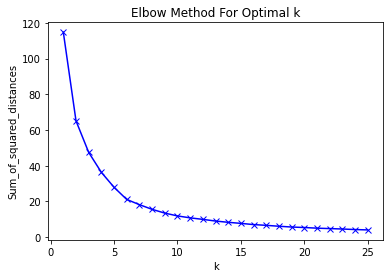

In [35]:
# See how many clusters we may want to group lisitings geographically into.
elbowPlot(df[['latitude', 'longitude']], 25)

In [36]:
# Split the data into training and testing sets
Train_df = df[df['listing_month'] <= 5]
Test_df = df[df['listing_month'] > 5]

# Train our new model
model4, cluster_model = newModel(Train_df, ['latitude', 'longitude'], 25,
                                 ['bedrooms', 'bathrooms','amenities',
                                  'words_in_description'],
                                 'price')

         training
MAE    786.915873
R2       0.541947
RMSE  1192.588579


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
# Evaluate with the test data
testNewModel(Test_df, ['latitude', 'longitude'], ['bedrooms', 'bathrooms','amenities',
                                                  'words_in_description'],
                                        'price', cluster_model, model4)

          testing
MAE    792.742014
R2       0.551608
RMSE  1180.513767


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Let's look at how the listings were clustered

Just the training data. It gets pretty dense enough.

In [38]:
# Make a data frame for mapping, just the coordinates and cluster labels
geo_df = Train_df
geo_df['cluster'] = cluster_model.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
import plotly.graph_objects as go

fig = go.Figure(layout=dict(height=1000, width=1000))

fig.add_trace(go.Scattermapbox(
    lat=geo_df['latitude'],
    lon=geo_df['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=5,
        color=geo_df['cluster'],
        opacity=0.8
    )
))

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(mapbox=dict(center=dict(lat=40.730610, lon= -73.9),
                              zoom=10))


In [0]:
import plotly.io as pio
pio.write_html(fig, file='map.html', auto_open=True)